# Лабораторная работа 1, вариант 7
## Регрессионный анализ прочности бетона на сжатие

**Разведочный анализ и регрессия с использованием нейронных сетей**

- **Датасет:** Прочность бетона на сжатие
- **Модели:** Полносвязная Dense НС, 1D сверточная НС
- **Преобразование данных:** Стандартизация
- **Метрики качества регрессии:** RMSE, R²

## 1. Импорт библиотек и конфигурация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, Dict, List
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression

import os
os.environ['KERAS_BACKEND'] = 'jax'

import keras
from keras import layers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Конфигурация
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
import random
random.seed(RANDOM_STATE)

# Настройка стиля графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Директория для артефактов
output_dir = Path('lab_1_artifacts')
output_dir.mkdir(exist_ok=True)

print("Библиотеки загружены")

Библиотеки загружены


## 2. Загрузка данных

In [3]:
def load_data(file_path: str) -> pd.DataFrame:
    """Загрузить датасет с бетоном."""
    df = pd.read_csv(file_path, index_col=0)
    df.columns = df.columns.str.strip()
    print("=" * 60)
    print("ДАТАСЕТ ЗАГРУЖЕН")
    print("=" * 60)
    print(f"Размерность: {df.shape}")
    print(f"\nКолонки: {list(df.columns)}")
    print(f"\nТипы данных:\n{df.dtypes}")
    return df

In [4]:
df = load_data('V7_dataset.csv')

ДАТАСЕТ ЗАГРУЖЕН
Размерность: (1030, 9)

Колонки: ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_compressive_strength']

Типы данных:
cement                           float64
blast_furnace_slag               float64
fly_ash                          float64
water                            float64
superplasticizer                 float64
coarse_aggregate                 float64
fine_aggregate                   float64
age                                int64
concrete_compressive_strength    float64
dtype: object


## 3. Описательная статистика

In [5]:
def descriptive_stats(df: pd.DataFrame) -> None:
    """Показать описательную статистику."""
    print("\n" + "=" * 60)
    print("ОПИСАТЕЛЬНАЯ СТАТИСТИКА")
    print("=" * 60)
    print(df.describe())

    print("\n" + "-" * 60)
    print("ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    print("-" * 60)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Количество пропусков': missing,
        'Процент': missing_pct
    })
    print(missing_df[missing_df['Количество пропусков'] > 0])

    if missing.sum() == 0:
        print("Пропущенных значений не найдено!")

In [6]:
descriptive_stats(df)


ОПИСАТЕЛЬНАЯ СТАТИСТИКА
            cement  blast_furnace_slag     fly_ash        water  \
count  1030.000000         1030.000000  496.000000  1030.000000   
mean    281.167864           73.895825   52.169556   181.567282   
std     104.506364           86.279342   62.846995    21.354219   
min     102.000000            0.000000    0.000000   121.800000   
25%     192.375000            0.000000    0.000000   164.900000   
50%     272.900000           22.000000    0.000000   185.000000   
75%     350.000000          142.950000  118.200000   192.000000   
max     540.000000          359.400000  200.100000   247.000000   

       superplasticizer  coarse_aggregate  fine_aggregate          age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.204660        972.918932      773.580485    45.662136   
std            5.973841         77.753954       80.175980    63.169912   
min            0.000000        801.000000      594.000000     1.000000   
2

## 4. Одномерные визуализации

In [7]:
def plot_distributions(df: pd.DataFrame, output_dir: Path) -> None:
    """Построить одномерные распределения для всех признаков."""
    print("\n" + "=" * 60)
    print("ПОСТРОЕНИЕ ОДНОМЕРНЫХ ВИЗУАЛИЗАЦИЙ")
    print("=" * 60)

    output_dir.mkdir(parents=True, exist_ok=True)

    for col in df.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax1.set_xlabel(col)
        ax1.set_ylabel('Частота')
        ax1.set_title(f'Распределение {col}')
        ax1.grid(True, alpha=0.3)

        ax2.boxplot(df[col].dropna(), vert=True)
        ax2.set_ylabel(col)
        ax2.set_title(f'Box Plot для {col}')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(output_dir / f'dist_{col}.png', dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()

    print(f"Сохранено {len(df.columns)} графиков распределений в {output_dir}")


ПОСТРОЕНИЕ ОДНОМЕРНЫХ ВИЗУАЛИЗАЦИЙ


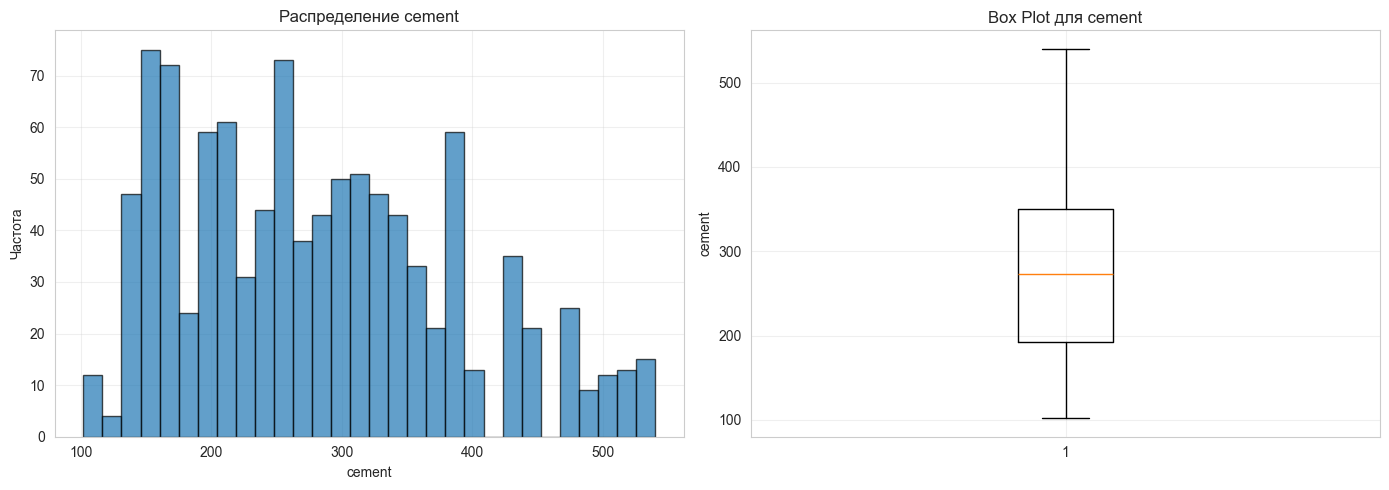

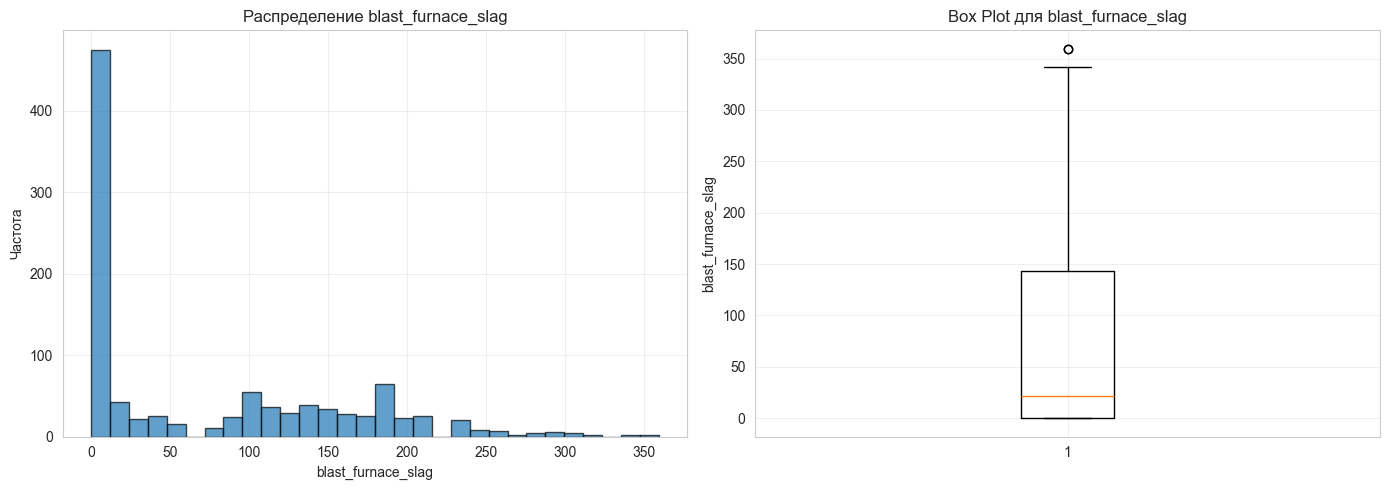

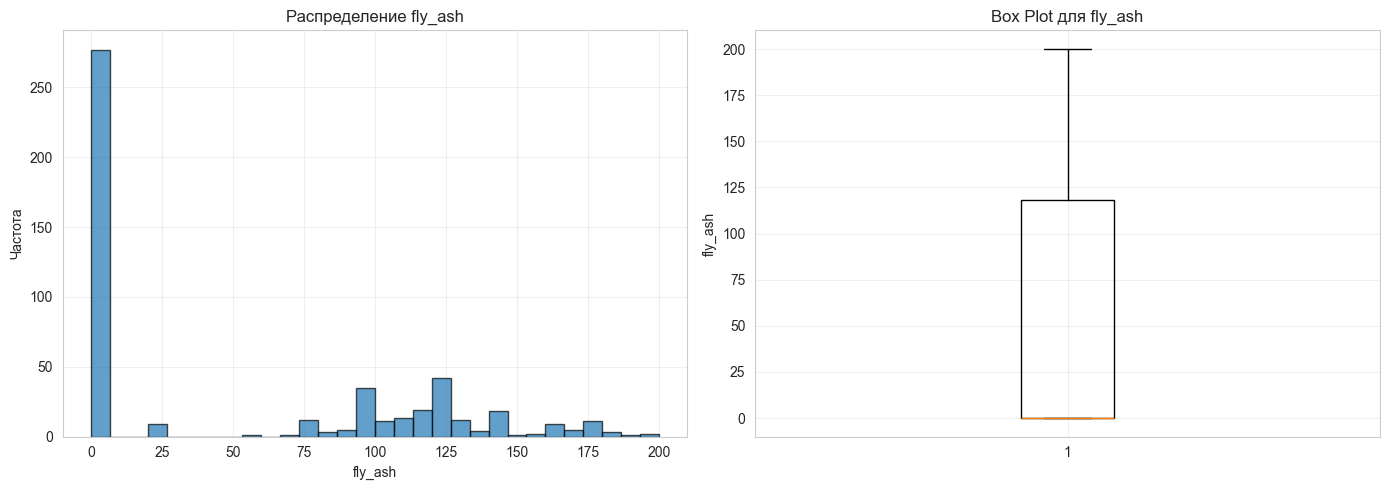

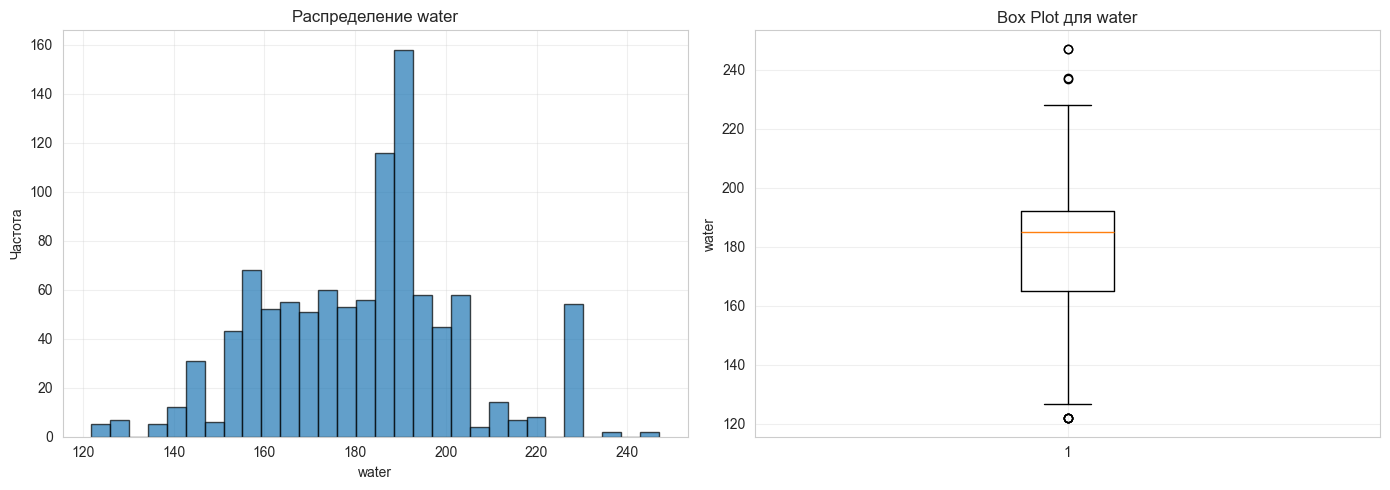

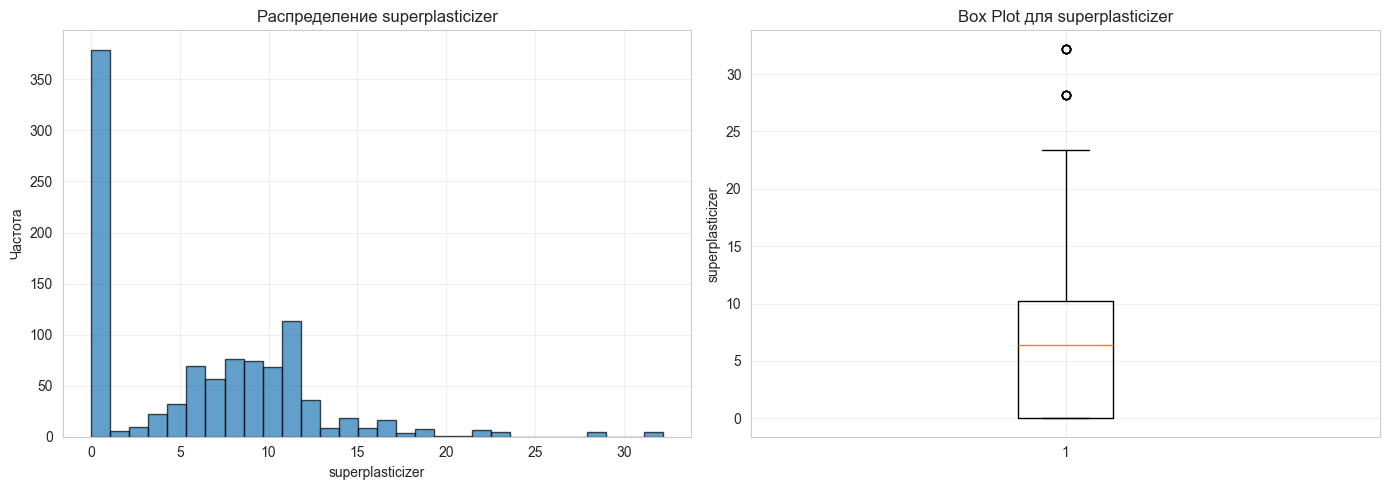

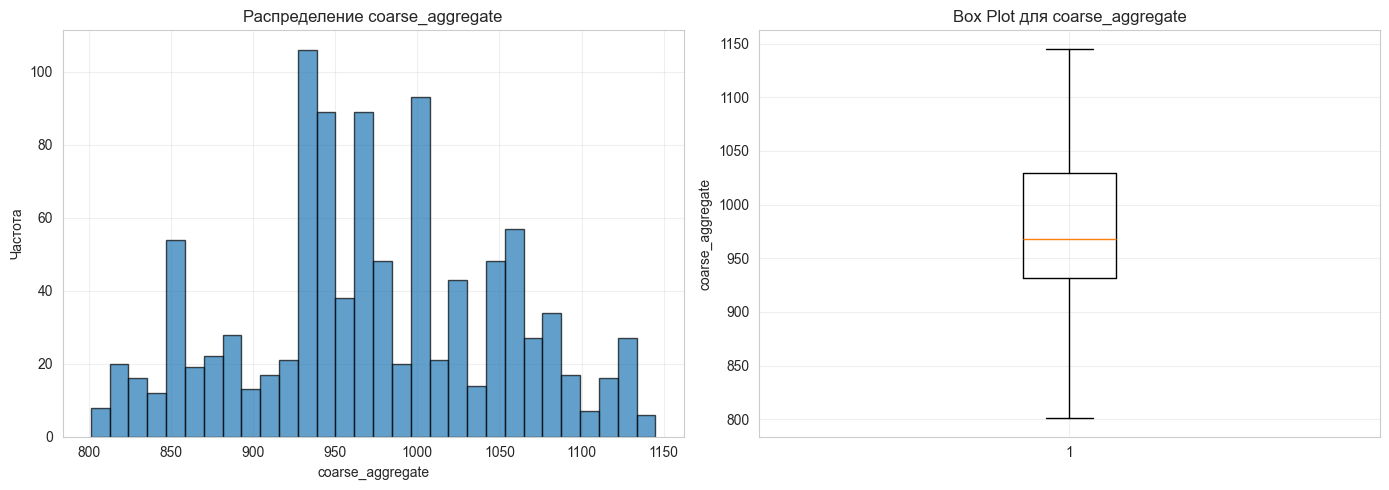

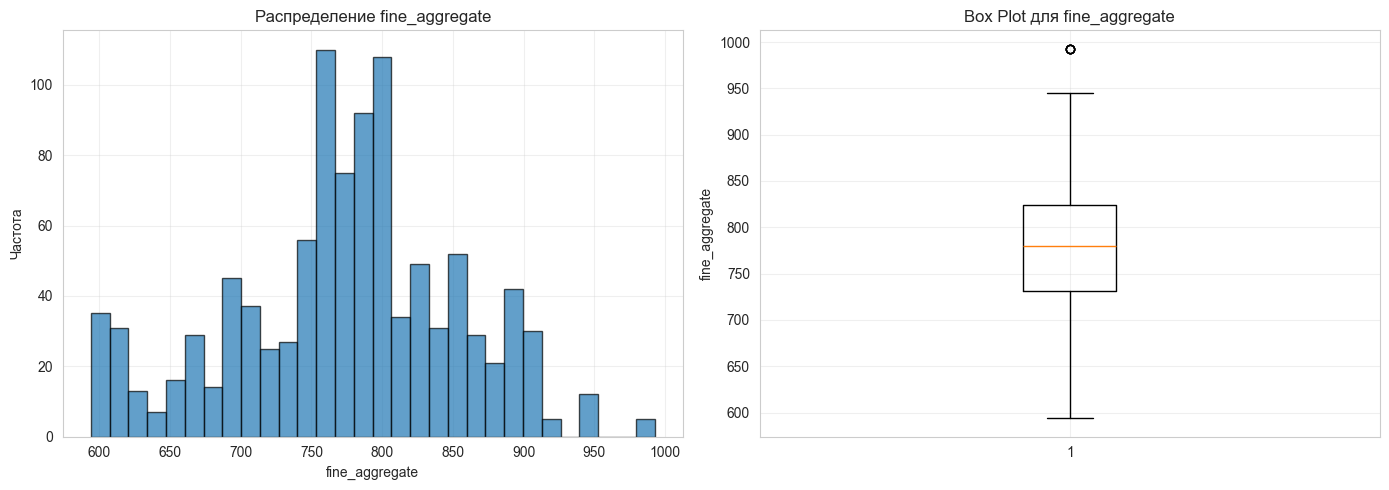

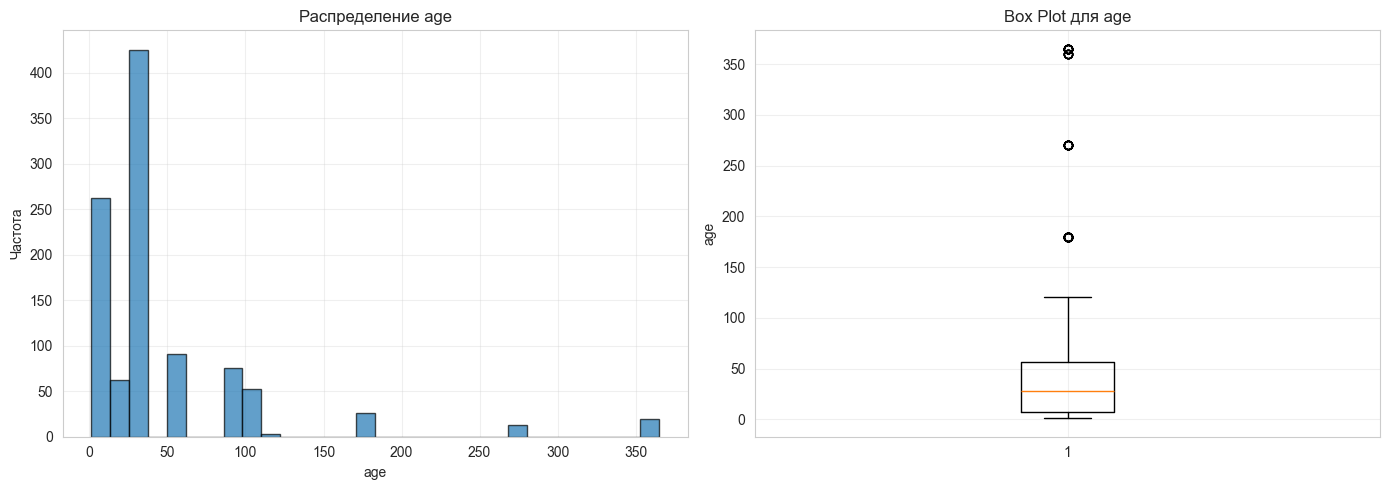

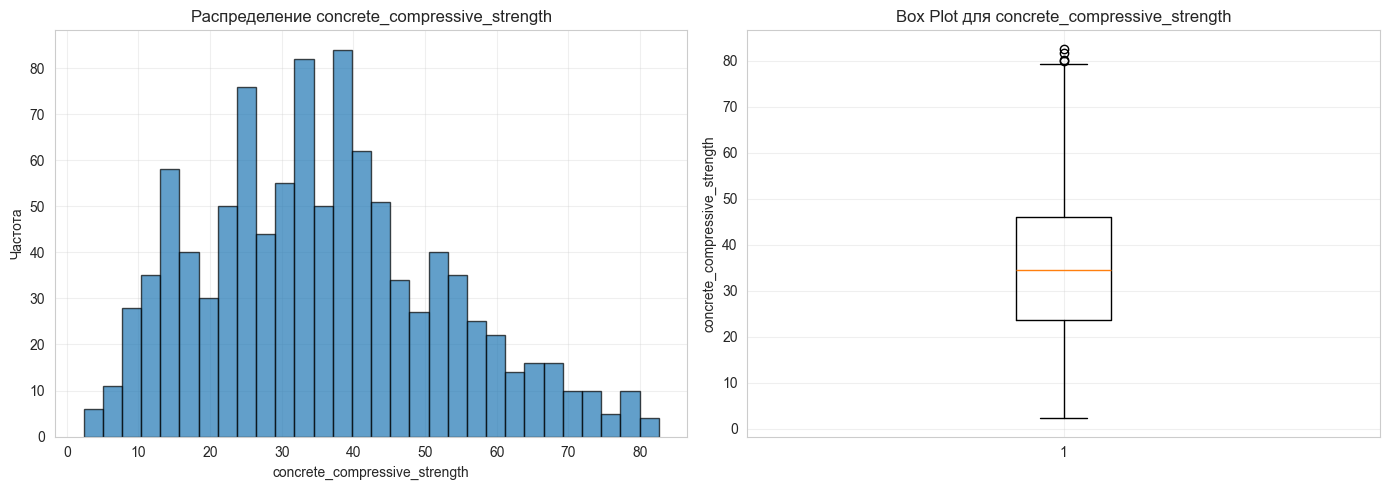

Сохранено 9 графиков распределений в lab_1_artifacts


In [8]:
plot_distributions(df, output_dir)

## 5. Многомерные визуализации (корреляции)

In [9]:
def plot_correlations(df: pd.DataFrame, output_dir: Path) -> None:
    """Построить тепловую карту корреляций и scatter-графики."""
    print("\n" + "=" * 60)
    print("ПОСТРОЕНИЕ МНОГОМЕРНЫХ ВИЗУАЛИЗАЦИЙ")
    print("=" * 60)

    # Тепловая карта корреляций
    plt.figure(figsize=(12, 10))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1)
    plt.title('Тепловая карта корреляций', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'correlation_heatmap.png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    print("Тепловая карта корреляций сохранена")

    # Корреляции с целевой переменной
    target = 'concrete_compressive_strength'
    if target in df.columns:
        correlations_with_target = df.corr()[target].sort_values(ascending=False)
        print(f"\nКорреляции с {target}:")
        print(correlations_with_target)

        # Scatter-графики
        features = [col for col in df.columns if col != target]
        n_features = len(features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten() if n_features > 1 else [axes]

        for idx, feature in enumerate(features):
            ax = axes[idx]
            ax.scatter(df[feature], df[target], alpha=0.5, s=20)
            ax.set_xlabel(feature)
            ax.set_ylabel(target)
            ax.set_title(f'{feature} vs {target}')
            ax.grid(True, alpha=0.3)

            corr = df[[feature, target]].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'r = {corr:.3f}',
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round',
                   facecolor='wheat', alpha=0.5))

        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.savefig(output_dir / 'scatter_plots.png', dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Сохранены scatter-графики для {n_features} признаков")


ПОСТРОЕНИЕ МНОГОМЕРНЫХ ВИЗУАЛИЗАЦИЙ


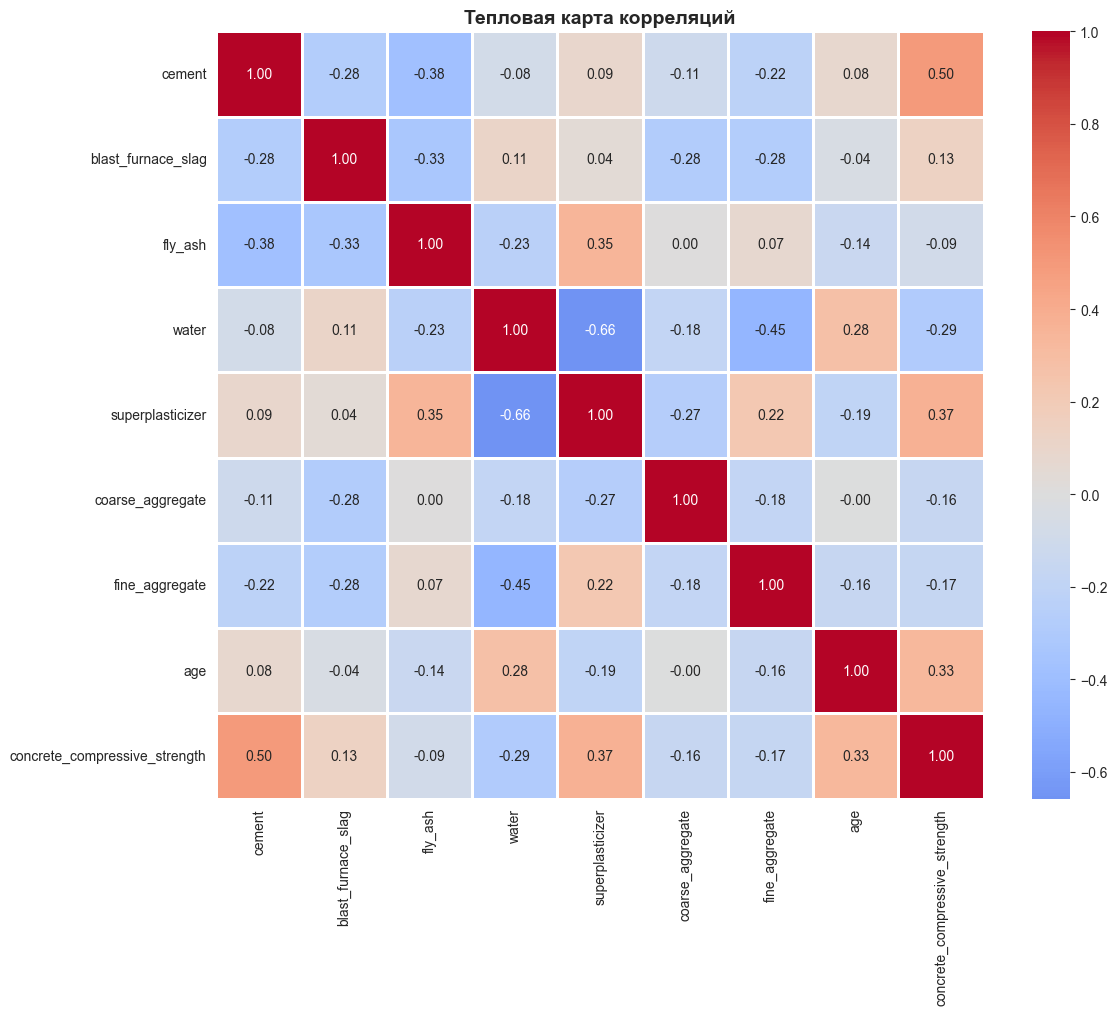

Тепловая карта корреляций сохранена

Корреляции с concrete_compressive_strength:
concrete_compressive_strength    1.000000
cement                           0.497832
superplasticizer                 0.366079
age                              0.328873
blast_furnace_slag               0.134829
fly_ash                         -0.093628
coarse_aggregate                -0.164935
fine_aggregate                  -0.167241
water                           -0.289633
Name: concrete_compressive_strength, dtype: float64


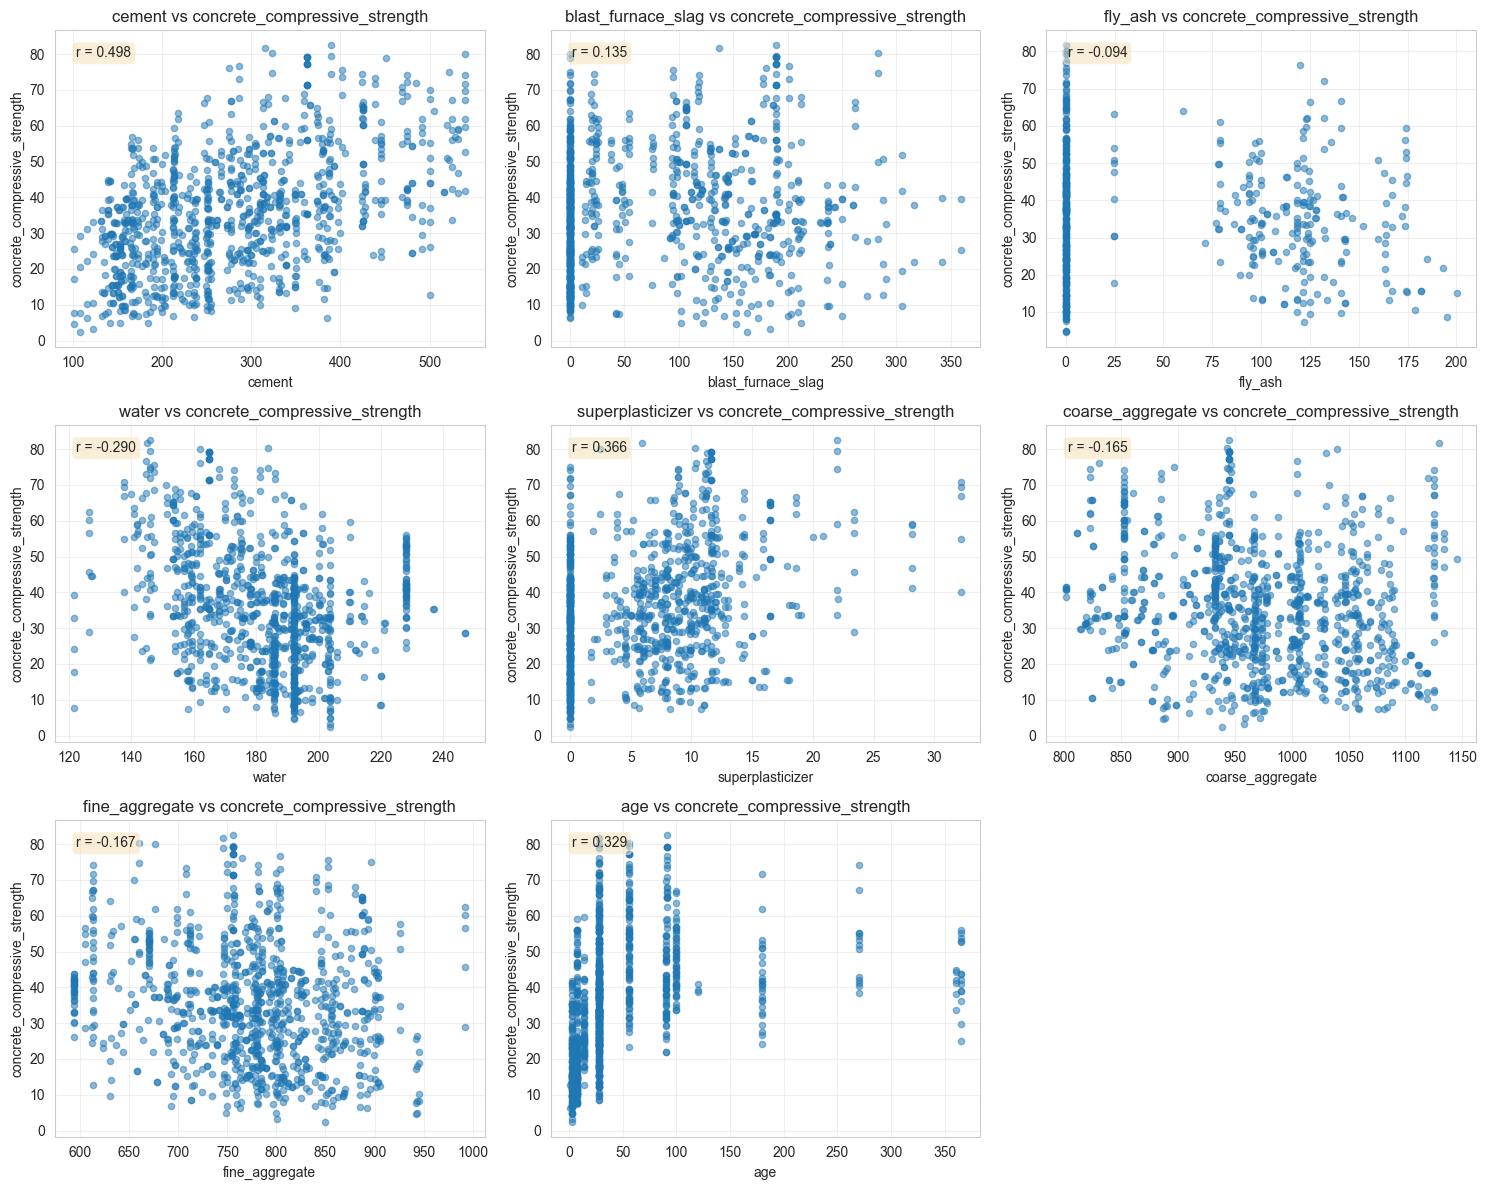

Сохранены scatter-графики для 8 признаков


In [10]:
plot_correlations(df, output_dir)

## 6. Очистка данных

In [11]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Очистить датасет: обработать пропуски и дубликаты."""
    print("\n" + "=" * 60)
    print("ОЧИСТКА ДАННЫХ")
    print("=" * 60)

    df_clean = df.copy()

    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"Пропуски в {col} заполнены медианой: {median_val:.2f}")

    n_duplicates = df_clean.duplicated().sum()
    if n_duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Удалено дубликатов строк: {n_duplicates}")
    else:
        print("Дубликаты строк не найдены")

    print(f"Итоговая форма датасета: {df_clean.shape}")
    return df_clean

In [12]:
df_clean = clean_data(df)


ОЧИСТКА ДАННЫХ
Пропуски в fly_ash заполнены медианой: 0.00
Удалено дубликатов строк: 25
Итоговая форма датасета: (1005, 9)


## 7. Инжиниринг признаков

In [13]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Создать доменно-специфичные инженерные признаки."""
    print("\n" + "=" * 60)
    print("ИНЖИНИРИНГ ПРИЗНАКОВ")
    print("=" * 60)

    df_eng = df.copy()

    # Водоцементное отношение (критично для прочности бетона)
    df_eng['water_cement_ratio'] = df_eng['water'] / (df_eng['cement'] + 1e-6)

    # Суммарный заполнитель
    df_eng['total_aggregate'] = df_eng['coarse_aggregate'] + df_eng['fine_aggregate']

    # Общее содержание вяжущих (цементирующие материалы)
    df_eng['binder_content'] = (df_eng['cement'] +
                                  df_eng['blast_furnace_slag'] +
                                  df_eng['fly_ash'])

    # Водно-вяжущее отношение
    df_eng['water_binder_ratio'] = df_eng['water'] / (df_eng['binder_content'] + 1e-6)

    # Возраст в квадрате (нелинейный эффект возраста)
    df_eng['age_squared'] = df_eng['age'] ** 2

    # Логарифм возраста
    df_eng['age_log'] = np.log(df_eng['age'] + 1)

    new_features = ['water_cement_ratio', 'total_aggregate', 'binder_content',
                    'water_binder_ratio', 'age_squared', 'age_log']
    print(f"Создано новых признаков: {len(new_features)}")
    for feat in new_features:
        print(f"  - {feat}")

    print(f"Всего признаков: {df_eng.shape[1]}")
    return df_eng

In [14]:
df_eng = engineer_features(df_clean)


ИНЖИНИРИНГ ПРИЗНАКОВ
Создано новых признаков: 6
  - water_cement_ratio
  - total_aggregate
  - binder_content
  - water_binder_ratio
  - age_squared
  - age_log
Всего признаков: 15


## 8. Подготовка наборов данных

In [15]:
def select_features(X: pd.DataFrame, y: pd.Series, top_fraction: float = 0.7) -> Tuple[pd.DataFrame, List[str]]:
    """Выбрать топ-признаки на основе взаимной информации."""
    print("\n" + "=" * 60)
    print("ОТБОР ПРИЗНАКОВ")
    print("=" * 60)

    mi_scores = mutual_info_regression(X, y, random_state=RANDOM_STATE)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

    print(f"\nОценки взаимной информации:")
    print(mi_scores)

    n_features = max(1, int(len(mi_scores) * top_fraction))
    selected_features = mi_scores.head(n_features).index.tolist()

    print(f"\nВыбрано топ {n_features} признаков ({top_fraction*100:.0f}%):")
    for feat in selected_features:
        print(f"  - {feat} (MI: {mi_scores[feat]:.4f})")

    return X[selected_features], selected_features


def prepare_datasets(df: pd.DataFrame, target_col: str) -> Dict:
    """Подготовить 4 набора данных: original, original_scaled, selected, selected_scaled."""
    print("\n" + "=" * 60)
    print("ПОДГОТОВКА НАБОРОВ ДАННЫХ")
    print("=" * 60)

    y = df[target_col].values
    X = df.drop(columns=[target_col])

    print(f"Всего объектов: {len(y)}")
    print(f"Всего признаков (с инженерными): {X.shape[1]}")

    X_selected, _ = select_features(X, y, top_fraction=0.7)

    datasets = {}

    for name, features in [('original', X), ('selected', X_selected)]:
        X_temp, X_test, y_temp, y_test = train_test_split(
            features, y, test_size=0.15, random_state=RANDOM_STATE
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE
        )

        datasets[name] = {
            'X_train': X_train.values,
            'X_val': X_val.values,
            'X_test': X_test.values,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'feature_names': features.columns.tolist(),
            'scaler': None
        }

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        datasets[f'{name}_scaled'] = {
            'X_train': X_train_scaled,
            'X_val': X_val_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'feature_names': features.columns.tolist(),
            'scaler': scaler
        }

    print(f"\nСоздано 4 набора данных:")
    for name, data in datasets.items():
        print(f"  - {name}: {data['X_train'].shape[1]} признаков, "
              f"train={len(data['y_train'])}, val={len(data['y_val'])}, "
              f"test={len(data['y_test'])}")

    return datasets

In [16]:
datasets = prepare_datasets(df_eng, target_col='concrete_compressive_strength')


ПОДГОТОВКА НАБОРОВ ДАННЫХ
Всего объектов: 1005
Всего признаков (с инженерными): 14

ОТБОР ПРИЗНАКОВ

Оценки взаимной информации:
water_binder_ratio    0.418447
water_cement_ratio    0.382302
age                   0.314054
age_log               0.312373
age_squared           0.271366
binder_content        0.270186
water                 0.268870
cement                0.232591
coarse_aggregate      0.186661
total_aggregate       0.170683
superplasticizer      0.142559
fine_aggregate        0.137042
blast_furnace_slag    0.104500
fly_ash               0.002622
dtype: float64

Выбрано топ 9 признаков (70%):
  - water_binder_ratio (MI: 0.4184)
  - water_cement_ratio (MI: 0.3823)
  - age (MI: 0.3141)
  - age_log (MI: 0.3124)
  - age_squared (MI: 0.2714)
  - binder_content (MI: 0.2702)
  - water (MI: 0.2689)
  - cement (MI: 0.2326)
  - coarse_aggregate (MI: 0.1867)

Создано 4 набора данных:
  - original: 14 признаков, train=703, val=151, test=151
  - original_scaled: 14 признаков, train=703, 

## 9. Построение моделей нейронных сетей

In [17]:
def build_dense_model(input_dim: int, hidden_units: int = 128,
                      dropout: float = 0.3, learning_rate: float = 0.001) -> keras.Model:
    """Собрать полносвязную (Dense) нейросеть."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units // 2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units // 4, activation='relu'),
        layers.Dropout(dropout * 0.7),
        layers.Dense(1)  # Линейная активация для регрессии
    ], name='Dense_Model')

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model


def build_conv1d_model(input_dim: int, filters: int = 64, kernel_size: int = 3,
                       dropout: float = 0.3, learning_rate: float = 0.001) -> keras.Model:
    """Собрать 1D сверточную нейросеть."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        layers.Conv1D(filters, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(filters * 2, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout * 0.7),
        layers.Dense(1)
    ], name='Conv1D_Model')

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

## 10. Функции обучения и оценки

In [18]:
def evaluate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Посчитать метрики регрессии."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'rmse': float(rmse), 'r2': float(r2), 'mae': float(mae)}


def train_model(model: keras.Model, X_train: np.ndarray, y_train: np.ndarray,
                X_val: np.ndarray, y_val: np.ndarray, epochs: int = 200,
                batch_size: int = 32, verbose: int = 0) -> keras.callbacks.History:
    """Обучить модель нейросети."""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=0
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )
    return history

## 11. Обучение всех моделей на всех наборах данных

In [19]:
def train_and_evaluate_all(datasets: Dict, epochs: int = 200) -> Dict:
    """Обучить обе модели на всех 4 наборах данных."""
    print("\n" + "=" * 60)
    print("ОБУЧЕНИЕ И ОЦЕНКА")
    print("=" * 60)

    results = {}
    all_models = {}

    for dataset_name, dataset in datasets.items():
        print(f"\n{'-' * 60}")
        print(f"Набор данных: {dataset_name}")
        print(f"{'-' * 60}")

        X_train = dataset['X_train']
        X_val = dataset['X_val']
        y_train = dataset['y_train']
        y_val = dataset['y_val']

        input_dim = X_train.shape[1]
        results[dataset_name] = {}
        all_models[dataset_name] = {}

        # Dense модель
        print(f"\nОбучение Dense-модели...")
        dense_model = build_dense_model(input_dim)
        train_model(dense_model, X_train, y_train, X_val, y_val, epochs=epochs, verbose=0)

        y_train_pred = dense_model.predict(X_train, verbose=0).flatten()
        y_val_pred = dense_model.predict(X_val, verbose=0).flatten()

        train_metrics = evaluate_metrics(y_train, y_train_pred)
        val_metrics = evaluate_metrics(y_val, y_val_pred)

        results[dataset_name]['dense'] = {'train': train_metrics, 'val': val_metrics}
        all_models[dataset_name]['dense'] = dense_model

        print(f"Dense - Train RMSE: {train_metrics['rmse']:.4f}, R²: {train_metrics['r2']:.4f}")
        print(f"Dense - Val   RMSE: {val_metrics['rmse']:.4f}, R²: {val_metrics['r2']:.4f}")

        # Conv1D модель
        print(f"\nОбучение Conv1D-модели...")
        X_train_conv = X_train.reshape(-1, input_dim, 1)
        X_val_conv = X_val.reshape(-1, input_dim, 1)

        conv_model = build_conv1d_model(input_dim)
        train_model(conv_model, X_train_conv, y_train, X_val_conv, y_val, epochs=epochs, verbose=0)

        y_train_pred = conv_model.predict(X_train_conv, verbose=0).flatten()
        y_val_pred = conv_model.predict(X_val_conv, verbose=0).flatten()

        train_metrics = evaluate_metrics(y_train, y_train_pred)
        val_metrics = evaluate_metrics(y_val, y_val_pred)

        results[dataset_name]['conv1d'] = {'train': train_metrics, 'val': val_metrics}
        all_models[dataset_name]['conv1d'] = conv_model

        print(f"Conv1D - Train RMSE: {train_metrics['rmse']:.4f}, R²: {train_metrics['r2']:.4f}")
        print(f"Conv1D - Val   RMSE: {val_metrics['rmse']:.4f}, R²: {val_metrics['r2']:.4f}")

    return results, all_models

In [20]:
results, all_models = train_and_evaluate_all(datasets, epochs=200)


ОБУЧЕНИЕ И ОЦЕНКА

------------------------------------------------------------
Набор данных: original
------------------------------------------------------------

Обучение Dense-модели...
Dense - Train RMSE: 22.2559, R²: -0.8784
Dense - Val   RMSE: 19.7731, R²: -0.5482

Обучение Conv1D-модели...
Conv1D - Train RMSE: 17.1162, R²: -0.1110
Conv1D - Val   RMSE: 17.2533, R²: -0.1787

------------------------------------------------------------
Набор данных: original_scaled
------------------------------------------------------------

Обучение Dense-модели...
Dense - Train RMSE: 5.1827, R²: 0.8981
Dense - Val   RMSE: 5.1191, R²: 0.8962

Обучение Conv1D-модели...
Conv1D - Train RMSE: 3.9478, R²: 0.9409
Conv1D - Val   RMSE: 4.8613, R²: 0.9064

------------------------------------------------------------
Набор данных: selected
------------------------------------------------------------

Обучение Dense-модели...
Dense - Train RMSE: 30.8842, R²: -2.6171
Dense - Val   RMSE: 25.3980, R²: -1.554

## 12. Поиск лучшей модели

In [21]:
def find_best_model(results: Dict, datasets: Dict, all_models: Dict) -> Dict:
    """Найти лучшую модель по RMSE на валидации."""
    print("\n" + "=" * 60)
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print("=" * 60)

    comparison = []
    for dataset_name in results:
        for model_name in results[dataset_name]:
            val_rmse = results[dataset_name][model_name]['val']['rmse']
            val_r2 = results[dataset_name][model_name]['val']['r2']
            train_rmse = results[dataset_name][model_name]['train']['rmse']
            train_r2 = results[dataset_name][model_name]['train']['r2']

            comparison.append({
                'dataset': dataset_name,
                'model': model_name,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'val_rmse': val_rmse,
                'val_r2': val_r2
            })

    comparison_df = pd.DataFrame(comparison)
    comparison_df = comparison_df.sort_values('val_rmse')

    print("\nКачество всех моделей (отсортировано по RMSE на валидации):")
    print(comparison_df.to_string(index=False))

    best = comparison_df.iloc[0]
    best_dataset = best['dataset']
    best_model_name = best['model']

    print(f"\n{'=' * 60}")
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name} на {best_dataset}")
    print(f"{'=' * 60}")
    print(f"RMSE на валидации: {best['val_rmse']:.4f}")
    print(f"R² на валидации:   {best['val_r2']:.4f}")

    dataset = datasets[best_dataset]
    model = all_models[best_dataset][best_model_name]

    X_test = dataset['X_test']
    y_test = dataset['y_test']

    if best_model_name == 'conv1d':
        X_test = X_test.reshape(-1, X_test.shape[1], 1)

    y_test_pred = model.predict(X_test, verbose=0).flatten()
    test_metrics = evaluate_metrics(y_test, y_test_pred)

    print(f"\nКачество на тесте:")
    print(f"Test RMSE: {test_metrics['rmse']:.4f}")
    print(f"Test R²:   {test_metrics['r2']:.4f}")
    print(f"Test MAE:  {test_metrics['mae']:.4f}")

    return {
        'dataset_name': best_dataset,
        'model_name': best_model_name,
        'dataset': dataset,
        'model': model,
        'test_metrics': test_metrics,
        'val_metrics': {'rmse': best['val_rmse'], 'r2': best['val_r2']},
        'comparison_df': comparison_df
    }

In [22]:
best_info = find_best_model(results, datasets, all_models)


СРАВНЕНИЕ МОДЕЛЕЙ

Качество всех моделей (отсортировано по RMSE на валидации):
        dataset  model  train_rmse  train_r2  val_rmse    val_r2
original_scaled conv1d    3.947842  0.940898  4.861263  0.906423
original_scaled  dense    5.182725  0.898140  5.119086  0.896234
selected_scaled conv1d    4.770617  0.913695  5.793360  0.867098
selected_scaled  dense    6.772573  0.826063  6.194045  0.848078
       selected conv1d   11.432985  0.504316 10.931056  0.526853
       original conv1d   17.116169 -0.110961 17.253319 -0.178737
       original  dense   22.255937 -0.878354 19.773127 -0.548183
       selected  dense   30.884241 -2.617092 25.398036 -1.554299

ЛУЧШАЯ МОДЕЛЬ: conv1d на original_scaled
RMSE на валидации: 4.8613
R² на валидации:   0.9064

Качество на тесте:
Test RMSE: 5.5932
Test R²:   0.8859
Test MAE:  4.0725


## 13. Grid Search

In [23]:
def grid_search(dataset: Dict, model_type: str, epochs: int = 150) -> Dict:
    """Выполнить grid search для подбора гиперпараметров."""
    print("\n" + "=" * 60)
    print(f"GRID SEARCH - {model_type.upper()}")
    print("=" * 60)

    X_train = dataset['X_train']
    X_val = dataset['X_val']
    y_train = dataset['y_train']
    y_val = dataset['y_val']
    input_dim = X_train.shape[1]

    if model_type == 'dense':
        param_grid = {
            'hidden_units': [64, 128],
            'dropout': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0005]
        }
    else:
        param_grid = {
            'filters': [64, 128],
            'kernel_size': [3, 5],
            'dropout': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0005]
        }
        X_train = X_train.reshape(-1, input_dim, 1)
        X_val = X_val.reshape(-1, input_dim, 1)

    best_score = float('inf')
    best_params = None
    best_model = None

    import itertools
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]
    combinations = list(itertools.product(*param_values))

    print(f"Тестируется комбинаций параметров: {len(combinations)}...")

    for idx, values in enumerate(combinations, 1):
        params = dict(zip(param_names, values))

        if model_type == 'dense':
            model = build_dense_model(
                input_dim,
                hidden_units=params['hidden_units'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )
        else:
            model = build_conv1d_model(
                input_dim,
                filters=params['filters'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )

        train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, verbose=0)

        y_val_pred = model.predict(X_val, verbose=0).flatten()
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        val_r2 = r2_score(y_val, y_val_pred)

        print(f"  [{idx}/{len(combinations)}] {params} -> RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")

        if val_rmse < best_score:
            best_score = val_rmse
            best_params = params
            best_model = model

    print(f"\n{'=' * 60}")
    print(f"ЛУЧШИЕ ПАРАМЕТРЫ НАЙДЕНЫ")
    print(f"{'=' * 60}")
    print(f"Параметры: {best_params}")
    print(f"RMSE на валидации: {best_score:.4f}")

    y_val_pred = best_model.predict(X_val, verbose=0).flatten()
    val_metrics = evaluate_metrics(y_val, y_val_pred)

    return {
        'best_params': best_params,
        'best_model': best_model,
        'val_metrics': val_metrics
    }

In [24]:
grid_results = grid_search(
    best_info['dataset'],
    best_info['model_name'],
    epochs=150
)


GRID SEARCH - CONV1D
Тестируется комбинаций параметров: 24...
  [1/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.2, 'learning_rate': 0.001} -> RMSE: 4.6567, R²: 0.9141
  [2/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.2, 'learning_rate': 0.0005} -> RMSE: 4.8593, R²: 0.9065
  [3/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.3, 'learning_rate': 0.001} -> RMSE: 16.1809, R²: -0.0368
  [4/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.3, 'learning_rate': 0.0005} -> RMSE: 5.2341, R²: 0.8915
  [5/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.001} -> RMSE: 4.9300, R²: 0.9038
  [6/24] {'filters': 64, 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.0005} -> RMSE: 5.0500, R²: 0.8990
  [7/24] {'filters': 64, 'kernel_size': 5, 'dropout': 0.2, 'learning_rate': 0.001} -> RMSE: 4.5932, R²: 0.9165
  [8/24] {'filters': 64, 'kernel_size': 5, 'dropout': 0.2, 'learning_rate': 0.0005} -> RMSE: 4.6504, R²: 0.9144
  [9/24] {'filters': 64, 'kernel_size': 5, 

## 14. Финальная оценка на тестовой выборке

In [25]:
print("\n" + "=" * 60)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 60)

X_test = best_info['dataset']['X_test']
y_test = best_info['dataset']['y_test']

if best_info['model_name'] == 'conv1d':
    X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_test_pred = grid_results['best_model'].predict(X_test, verbose=0).flatten()
test_metrics_after = evaluate_metrics(y_test, y_test_pred)

print(f"\nДо Grid Search:")
print(f"  Test RMSE: {best_info['test_metrics']['rmse']:.4f}")
print(f"  Test R²:   {best_info['test_metrics']['r2']:.4f}")

print(f"\nПосле Grid Search:")
print(f"  Test RMSE: {test_metrics_after['rmse']:.4f}")
print(f"  Test R²:   {test_metrics_after['r2']:.4f}")

improvement_rmse = ((best_info['test_metrics']['rmse'] - test_metrics_after['rmse']) /
                    best_info['test_metrics']['rmse'] * 100)
improvement_r2 = ((test_metrics_after['r2'] - best_info['test_metrics']['r2']) /
                  abs(best_info['test_metrics']['r2']) * 100)

print(f"\nУлучшение:")
print(f"  RMSE: {improvement_rmse:+.2f}%")
print(f"  R²:   {improvement_r2:+.2f}%")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

До Grid Search:
  Test RMSE: 5.5932
  Test R²:   0.8859

После Grid Search:
  Test RMSE: 5.4754
  Test R²:   0.8907

Улучшение:
  RMSE: +2.11%
  R²:   +0.54%


## 15. Сохранение результатов

In [26]:
summary = {
    'best_model': best_info['model_name'],
    'best_dataset': best_info['dataset_name'],
    'results_before_grid_search': {
        'val_rmse': float(best_info['val_metrics']['rmse']),
        'val_r2': float(best_info['val_metrics']['r2']),
        'test_rmse': float(best_info['test_metrics']['rmse']),
        'test_r2': float(best_info['test_metrics']['r2']),
        'test_mae': float(best_info['test_metrics']['mae'])
    },
    'grid_search_params': grid_results['best_params'],
    'results_after_grid_search': {
        'val_rmse': float(grid_results['val_metrics']['rmse']),
        'val_r2': float(grid_results['val_metrics']['r2']),
        'test_rmse': float(test_metrics_after['rmse']),
        'test_r2': float(test_metrics_after['r2']),
        'test_mae': float(test_metrics_after['mae'])
    },
    'improvement': {
        'rmse_percentage': float(improvement_rmse),
        'r2_percentage': float(improvement_r2)
    },
    'all_models_comparison': best_info['comparison_df'].to_dict('records')
}

with open(output_dir / 'results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Результаты сохранены в", output_dir / 'results_summary.json')

Результаты сохранены в lab_1_artifacts/results_summary.json
